# Arctic Amplification and New York State Temperature Anomalies

---

## Overview

Arctic Amplification (AA) describes the arctic warming faster than the rest of the globe. First, we will use CFSR data from 1979-2021 to show that AA is occuring by comparing temperature anomalies between the poles and the mid-latitudes; more detailed definitions in relevant parts of this notebook. Next, we will explore trends in local NY State temperature anomalies by using NY State Mesonet data from 2017-2022 (through September). Lastly, we will look for relationships betwen AA and NYSM Temperature Anomalies, and discuss the limitations of looking at statistical relationships only.

- Section 1: Create Monthly and Annual Mean Datasets by Year from 1979-2022 using CFSR Data
- Section 2: Arctic Amplification Study using CFSR Data
- Section 3: NY State Temp Anomalies using NY State Mesonet (NYSM) Data
- Section 4: Connecting AA and NYSM Trends

---

## Imports

In [1]:
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# import datetime 
import os
import pandas as pd
from glob import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


## Section 1: Create Monthly and Annual Mean Datasets by Year from 1979-2022 using CFSR Data
<div class="alert alert-block alert-danger">
<ol>
    Section 1 is for <b><i> Reference Only </b></i> because the monthly mean computations take a long time to run at ~6 minutes per year (over 4 hours for the full 43 years of data). This code has already been ran and net cdf files have been saved out locally, so those files can be read in and used as pre-computed datasets for later parts of this notebook.
</ol>
</div>

Data source: Climate Forecast System Renanalysis, https://climatedataguide.ucar.edu/climate-data/climate-forecast-system-reanalysis-cfsr

Local copies (/cfsr/data/) of CFSR datasets were used in this notebook.

Referenced notebooks: UAlbany ATM622 Jupyter notebook https://brian-rose.github.io/general-circulation/lectures/computing-seasonal.html
 

### Define functions
Functions are used when creating and saving each monthly mean dataset by year

In [ ]:
def make_dir(path):
    """ 
    Input directory path as string
    Creates the directory if it doesn't already exist
    """ 
    if not os.path.exists(path):
        os.makedirs(path)
        
def open_ds(yr):
    """ Open dataset using dask """
    ds = xr.open_mfdataset(f'/cfsr/data/{yr}/{var}.{yr}.0p5.anl.nc', chunks={'time':30*4, 'lev': 4}, parallel=True) # removed this before /cfsr "/network/daes"
    return ds

def compute_save_means(ds_for_mean, yr):
    
    """ 
    Input dataset based depends on whether grouping seasonally, annually, etc.
    Perform lazy execution averaging on the input dataset
    Calculation is executed when saving to path
    """
    ds_mean = ds_for_mean.mean(dim=('lon','time'), skipna=True)
    save_path = f'{save_dir}/{group_desc}_{var}_{yr}.nc'
    ds_mean.to_netcdf(save_path)
    print(save_path) #comment out for final version
    print(f"finished {yr} at {datetime.datetime.now()}") #comment out for final version
    

### Create and save monthly mean temperature datasets for each year from 1979-2022

#### Define Variables

In [ ]:
# Define CFSR variable of interest (e.g. temperature is 't') 
var = 't' 

# Describes how data should be grouped for averaging, used in file and directory names
group_desc = 'monthly' 

# Directory where averaged net cdf files will be saved out
save_dir = f'/home11/grad/2021/cs436778/general-circulation/project/data/{group_desc}'

# Years of CFSR data to include; each will be looped over
years = range(1979, 2023) 

#### Execute monthly mean calculation for each year and save dataset

In [ ]:
# execute function monthl

make_dir(save_dir)

for year in years:

    ds = open_ds(year)

    # group dataframe depending on seasonal, annual, monthly means
    ds_grouped = ds.groupby(ds.time.dt.month)

    compute_save_means(ds_grouped, year)

### Create and save annual mean temperature datasets for each year from 1979-2022

#### Define Variables

In [ ]:
# Define CFSR variable of interest (e.g. temperature is 't') 
var = 't' 

# Describes how data should be grouped for averaging, used in file and directory names
group_desc = 'annual' 

# Directory where averaged net cdf files will be saved out
save_dir = f'/home11/grad/2021/cs436778/general-circulation/project/data/{group_desc}'

# Years of CFSR data to include; each will be looped over
years = range(1979, 2023)

#### Execute monthly mean calculation for each year and save dataset

In [ ]:
# execute function monthl

make_dir(save_dir)

for year in years:

    ds = open_ds(year)

    # group dataframe depending on seasonal, annual, monthly means
    ds_grouped = ds.groupby(ds.time.dt.year)

    compute_save_means(ds_grouped, year)

## Section 2: Arctic Amplification Study using CFSR Data

Recreate figures 1A and 2A from **Francis & Vavrus 2015**. 
- Citation and link to paper: Jennifer A Francis and Stephen J Vavrus 2015 Environ. Res. Lett. 10 014005,  https://iopscience.iop.org/article/10.1088/1748-9326/10/1/014005#erl507077bib8

### Subsection 2.1: Annual Mean Temperature Anomalies Figure
- Analogous to Francis & Vavrus Figure 1A: Annual-mean anomalies in air temperature for 40–80°N 
- **Annual anomaly** is defined as the difference in annual mean relative to the **1989-2018 mean** (30 years)
    - Note that this is updated from Francis & Vavrus' available data from 1981–2010 (30 years)
- Anomalies in air temperature are calculated for each year from **2003 through 2021** (19 years) and averaged to get annual-mean anomalies which are plotted by latitude and elevation. 
    - Note that this is updated from Francis & Vavrus' anomalies calculatued for 1995 through 2013 (19 years).
- Thus, all data ranges have been shifted forward 8 years

#### Define Variables

In [2]:
dir_annual_t = '/home11/grad/2021/cs436778/general-circulation/project/data/annual/'

# Define the years of data to use for Avg Temp Anomalies, both the years to calculate and the relative mean to subtract
years_calc = range(2003, 2022)
years_relative = range(1989, 2019)

#### Read in pre-computed annual mean datasets

In [3]:
# List all files from parent dir with the years defined
t_files_years_calc = []
for year in years_calc: 
    t_files_years_calc.append(f"{dir_annual_t}annual_t_{year}.nc")
    
# List all files from parent dir with the years defined
t_files_years_relative = []
for year in years_relative: 
    t_files_years_relative.append(f"{dir_annual_t}annual_t_{year}.nc")
    
# Read in datasets using dask
ds_years_calc = xr.open_mfdataset(t_files_years_calc, chunks={'time':30*4, 'lev': 4}, parallel=True)
ds_years_relative = xr.open_mfdataset(t_files_years_relative, chunks={'time':30*4, 'lev': 4}, parallel=True)

#### Calculate mean temp 1989 - 2018 to be used as relative temp in anomaly calculation

In [4]:
t_rel = ds_years_relative.mean(dim=('year'))
t_rel

<xarray.Dataset>
Dimensions:  (lev: 32, lat: 361)
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float32 1e+03 975.0 950.0 925.0 900.0 ... 50.0 30.0 20.0 10.0
Data variables:
    t        (lev, lat) float32 dask.array<chunksize=(4, 361), meta=np.ndarray>

#### Calculate mean temp for 2003 - 2021

Note that averaging and over 2003-2021 and then subtracting the relative temperature is *equivalent* to subtracting the relative temperature from each year (resulting in temp anomalies by year) and then averaging

In [5]:
t_calc = ds_years_calc.mean(dim=('year'))
t_calc

<xarray.Dataset>
Dimensions:  (lev: 32, lat: 361)
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float32 1e+03 975.0 950.0 925.0 900.0 ... 50.0 30.0 20.0 10.0
Data variables:
    t        (lev, lat) float32 dask.array<chunksize=(4, 361), meta=np.ndarray>

#### Calculate the annual-mean anomalies in air temperature by subtracting the two mean datasets created above


In [6]:
t_anom = t_calc - t_rel

#### Subset dataset to latitudes of interest, 40N-80N and reformat data for easy plotting

In [7]:
t_anom = t_anom.sel(lat=slice(40,80))
t_anom_da = t_anom.to_array(dim='t').squeeze(dim=["t"], drop = True) # reformats the data for easy plotting
t_anom_da

<xarray.DataArray (lev: 32, lat: 81)>
dask.array<getitem, shape=(32, 81), dtype=float32, chunksize=(4, 81), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 40.0 40.5 41.0 41.5 42.0 ... 78.0 78.5 79.0 79.5 80.0
  * lev      (lev) float32 1e+03 975.0 950.0 925.0 900.0 ... 50.0 30.0 20.0 10.0

#### Plot annual-mean temperature anomalies for 40N-80N

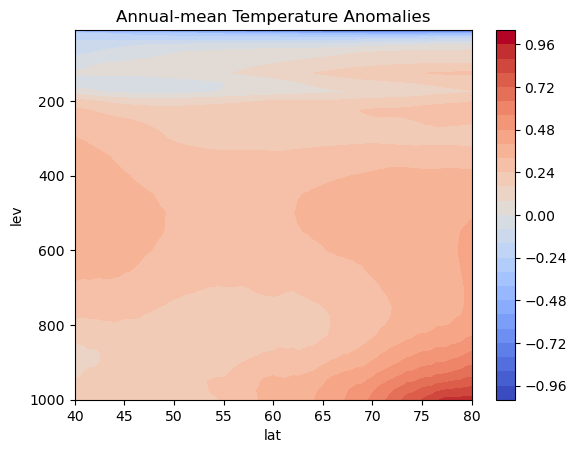

In [8]:
xr.plot.contourf(t_anom_da, x = 'lat', y = 'lev', levels = 30, yincrease=False, cmap = 'coolwarm')
plt.title("Annual-mean Temperature Anomalies");


### Subsection 2.2: Arctic Amplification Time Series

- Define **Arctic Amplification** as the difference in 1000 hPa temperature anomalies (relative to 1979–2021 mean), between the Arctic (70–90°N) and mid-latitudes (30–60°N)
    - Note that this is updated from Francis & Vavrus' available data from 1948–2013 mean
- Analogous to Francis & Vavrus Figure 2A

#### Read in pre-computed monthly and annual mean datasets

In [9]:
# Define the parent dir where annual temp data lives
# dir_seasonal_t = '/home11/grad/2021/cs436778/general-circulation/project/data/seasonal/'
dir_annual_t = '/home11/grad/2021/cs436778/general-circulation/project/data/annual/'
dir_monthly_t = '/home11/grad/2021/cs436778/general-circulation/project/data/monthly/'

# Define the years of data for Arctic Amplification Calculation
years = range(1979,2022)

leap = ['1980', '1984', '1988', '1992', '1996', '2000', '2004', '2008', '2012', '2016', '2020']

#### Define Functions 
For the mid-latitudes and the arctic, must calculate annual and seasonal means 1) by year and 2) as long-term climatologies over 43 years from 1979-2022

In [10]:
def latrange_mean(dataset, elev_p, latrange):
    """ 
    For each year, read in the seasonal dataset and subset by elevation and latitude range (ex: arctic and mid latitudes regions)
    Calculate the region's latitude-weighted mean temperature for each season
    """
    latrange = dataset.t.sel(lev=elev_p, lat = latrange)
    latrange_weights = np.cos(np.deg2rad(latrange.lat))
    latrange_mean = latrange.weighted(latrange_weights).mean(dim = 'lat')
    return latrange_mean
    
    
def add_to_dict(dict_name, key_name, val):
    """ 
    Append value to a specific key in dictionary if the key already exists
    Otherwise, if key doesn’t exist in dictionary, add a new key and its value to the dictionary 
    """
    if key_name in dict_name:
        if type(dict_name[key_name]) is not list:
            key_current_val = [dict_name[key_name]]
        else:
            key_current_val = dict_name[key_name]
        key_current_val.append(val)
        dict_name[key_name] = key_current_val
    else:
        dict_name[key_name] = val    
        
def yearly_monthly_means(dataset, dict_name):
    """
    For each season, track the year, season, and mean value (three keys)
    Returns a dictionary of the tracked data 
    """
    for month_num in range(1,13):
        month_val = dataset.sel(month = month_num).values.item()
        add_to_dict(dict_name, month_num, month_val)
        
def year_month_length(yr, dictname):
    """
    Identifies the length of day in a month or year depending on leap year
    Note: These lengths will be used for calculating seasonal and annual climatologies rather than using xarray's built in averaging over 'time.season' which is DJF rather than JFM
    """
    if yr in leap:
        add_to_dict(dictname, 'count_2', 29)
        add_to_dict(dictname, 'count_year', 366)
    else: 
        add_to_dict(dictname, 'count_2', 28)
        add_to_dict(dictname, 'count_year', 365)
    add_to_dict(dictname, 'count_1', 31)
    add_to_dict(dictname, 'count_3', 31)
    add_to_dict(dictname, 'count_4', 30)
    add_to_dict(dictname, 'count_5', 31)
    add_to_dict(dictname, 'count_6', 30)
    add_to_dict(dictname, 'count_7', 31)
    add_to_dict(dictname, 'count_8', 31)
    add_to_dict(dictname, 'count_9', 30)
    add_to_dict(dictname, 'count_10', 31)
    add_to_dict(dictname, 'count_11', 30)
    add_to_dict(dictname, 'count_12', 31)


def dict_month_data(plevel, lat_low, lat_high):
    """
    Create dictionary of temp data by month and year for a given latitude range and pressure level
    """
    new_dict = {}
    for year in years:
        
        # add year to dictionary
        year = str(year)
        add_to_dict(new_dict, 'year_name', year)
        
        # open datasets
        ds_year_month = xr.open_mfdataset(f"{dir_monthly_t}monthly_t_{year}.nc")
        ds_year = xr.open_mfdataset(f"{dir_annual_t}annual_t_{year}.nc")

        # subset datasets
        lat_avg_months = latrange_mean(ds_year_month, plevel, slice(lat_low,lat_high))
        lat_avg_year = latrange_mean(ds_year, plevel, slice(lat_low,lat_high))
        
        # add subsetted data to dictionary
        yearly_monthly_means(lat_avg_months, new_dict)
        add_to_dict(new_dict, 'annual', lat_avg_year.values.item())
        
        # add month length and year length to dictionary accounting for leap years
        year_month_length(year, new_dict)
            
    return new_dict

 
def seasonal_climatology(region_dict, months_ls):
    """ 
    Calculate seasonal climatologies, used for calculating anomalous temp
    Input regional dictionary of temps by month (e.g. arctic_dict made above) 
    Input list of month numbers to be averaged to create season (e.g. input list [1,2,3] to average Jan, Feb, Mar)
    Returns weighted average value (weighted by month length) and the length of season
    """
    month_values = region_dict[months_ls[0]] + region_dict[months_ls[1]] + region_dict[months_ls[2]]
    month_num_days = region_dict[f"count_{str(months_ls[0])}"] + region_dict[f"count_{str(months_ls[1])}"] + region_dict[f"count_{str(months_ls[2])}"]
    season_mean = np.average(month_values, weights = month_num_days)
    season_num_days = sum(month_num_days)
    return season_mean, season_num_days


def seasonal_anom(region_dict, months_ls, season_clim):
    """ 
    Create time series of temp anomalies by year & season 
    Input regional dictionary of temps 
    Input list of month numbers to be averaged to create season (e.g. input list [1,2,3] to average Jan, Feb, Mar)
    For each year, calculate the seasonal anomaly by averaging that season's months and then subtracting the seasonal climatology
    Returns timeseries list of seasonal temp anomalies from Winter 1979 through Fall 2021, seasonal weighted average value (weighted by month length) of season
    """
    season_t_ls = []
    for year_ind in range(0, len(region_dict['year_name'])):
        month_values = [region_dict[months_ls[0]][year_ind], region_dict[months_ls[1]][year_ind], region_dict[months_ls[2]][year_ind]]
        month_num_days = [region_dict[f"count_{str(months_ls[0])}"][year_ind], region_dict[f"count_{str(months_ls[1])}"][year_ind], region_dict[f"count_{str(months_ls[2])}"][year_ind]]
        season_mean = np.average(month_values, weights = month_num_days)
        season_t_ls.append(season_mean-season_clim)
    return season_t_ls

def annual_climatology(years_ls, plevel, lat_low, lat_high):
    """ 
    Calculate annual climatology for a given range of years, pressure level, and region (slice from lat_low to lat_high)
    """
    files_allyears = []
    for year in years_ls: 
        files_allyears.append(f"{dir_annual_t}annual_t_{year}.nc")

    ds_years = xr.open_mfdataset(files_allyears , chunks={'time':30*4, 'lev': 4}, parallel=True)

    latrange = ds_years.t.sel(lev=plevel, lat = slice(lat_low,lat_high))
    latrange_weights = np.cos(np.deg2rad(latrange.lat))
    latrange_mean = latrange.weighted(latrange_weights).mean(dim = 'lat')

    t_ann = latrange_mean.mean(dim=('year'))
    t_avg = t_ann.values.item()
    return t_avg

def annual_anom(region_dict, annual_clim):
    """ 
    Create time series of temp anomalies by year
    Input regional dictionary of temps
    Input annual climatology (relative temp for anomaly calc)
    For each year, calculate the annual anomaly by subtracting the seasonal climatology
    Returns timeseries list of seasonal temp anomalies from 1979 through 2021
    """
    annual_t_ls = []
    for year_ind in range(0, len(region_dict['year_name'])):
        annual_mean = region_dict['annual'][year_ind]
        annual_t_ls.append(annual_mean-annual_clim)
    return annual_t_ls


#### Create dictionaries holding monthly temperature from 1979 through 2022

In [11]:
midlat_dict_new = dict_month_data(1000, 30, 60)
arctic_dict_new = dict_month_data(1000, 70, 90)

#### Seasonal calculations

##### A) Seasonal climatologies

In [12]:
arctic_jfm_mean, arctic_jfm_len = seasonal_climatology(arctic_dict_new, [1,2,3])
midlat_jfm_mean, midlat_jfm_len = seasonal_climatology(midlat_dict_new, [1,2,3])

arctic_amj_mean, arctic_amj_len = seasonal_climatology(arctic_dict_new, [4,5,6])
midlat_amj_mean, midlat_amj_len = seasonal_climatology(midlat_dict_new, [4,5,6])

arctic_jas_mean, arctic_jas_len  = seasonal_climatology(arctic_dict_new, [7,8,9])
midlat_jas_mean, midlat_jas_len = seasonal_climatology(midlat_dict_new, [7,8,9])

arctic_ond_mean, arctic_ond_len  = seasonal_climatology(arctic_dict_new, [10,11,12])
midlat_ond_mean, midlat_ond_len = seasonal_climatology(midlat_dict_new, [10,11,12])

##### B) Seasonal anomalies timeseries

In [13]:
arctic_jfm_anom = seasonal_anom(arctic_dict_new, [1,2,3], arctic_jfm_mean)
midlat_jfm_anom = seasonal_anom(midlat_dict_new, [1,2,3], midlat_jfm_mean)

arctic_amj_anom = seasonal_anom(arctic_dict_new, [4,5,6], arctic_amj_mean)
midlat_amj_anom = seasonal_anom(midlat_dict_new, [4,5,6], midlat_amj_mean)

arctic_jas_anom = seasonal_anom(arctic_dict_new, [7,8,9], arctic_jas_mean)
midlat_jas_anom = seasonal_anom(midlat_dict_new, [7,8,9], midlat_jas_mean)

arctic_ond_anom = seasonal_anom(arctic_dict_new, [10,11,12], arctic_ond_mean)
midlat_ond_anom = seasonal_anom(midlat_dict_new, [10,11,12], midlat_ond_mean)

#### Annual calculations

##### A) Annual climatology

In [14]:
arctic_ann_mean = annual_climatology(years, 1000, 70, 90)
midlat_ann_mean = annual_climatology(years, 1000, 30, 60)

##### B) Annual anomalies timeseries

In [15]:
arctic_ann_anom = annual_anom(arctic_dict_new, arctic_ann_mean)
midlat_ann_anom = annual_anom(midlat_dict_new, midlat_ann_mean)

#### Calculate Arctic Amplification (AA) time series by season & annually

In [16]:
winter = np.array(arctic_jfm_anom) - np.array(midlat_jfm_anom)
spring = np.array(arctic_amj_anom) - np.array(midlat_amj_anom)
summer = np.array(arctic_jas_anom) - np.array(midlat_jas_anom)
fall = np.array(arctic_ond_anom) - np.array(midlat_ond_anom)
annual = np.array(arctic_ann_anom) - np.array(midlat_ann_anom)


#### Plot Arctic Amplification Time Series

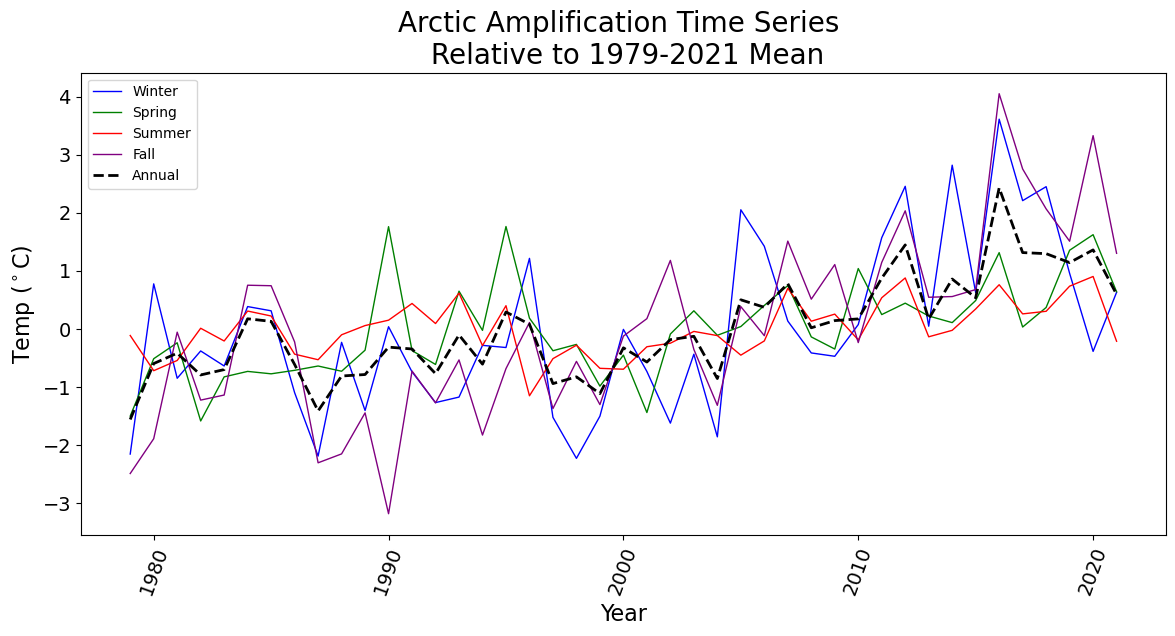

In [17]:
# Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

# add plot
ax1 = fig.add_subplot(1, 1, 1)

# plot values
ax1.plot(years, winter, label='Winter', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

##### Insights from Arctic Amplification time series
<div class="alert alert-block alert-success">
<ol>
Using CFSR data from 1979-2021, we've recreated Francis & Vavrus figure 2A showing Arctic Amplification occuring
</ol>
</div>

#### Create a dataframe of AA subsetetd to 2017-2021 for comparing to NYSM (see end of notebook, Section 4)

In [18]:
# subset datasets
yrs_cfsr_17_21 = years[38:43]
winter_cfsr_17_21 = winter[38:43]
spring_cfsr_17_21 = spring[38:43]
summer_cfsr_17_21 = summer[38:43]
fall_cfsr_17_21 = fall[38:43]
annual_cfsr_17_21 = annual[38:43]

def df_aa_subset():
    cfsr_2017_2021_flat = []
    for i in range(0, len(yrs_cfsr_17_21)):
        yr = yrs_cfsr_17_21[i]
        cfsr_2017_2021_flat.append((f"{yr}_JFM", f"{yr}_Season1", f"{round(winter_cfsr_17_21[i],2)}"))
        cfsr_2017_2021_flat.append((f"{yr}_AMJ", f"{yr}_Season2", f"{round(spring_cfsr_17_21[i],2)}"))
        cfsr_2017_2021_flat.append((f"{yr}_JAS", f"{yr}_Season3", f"{round(summer_cfsr_17_21[i],2)}"))
        cfsr_2017_2021_flat.append((f"{yr}_OND", f"{yr}_Season4", f"{round(fall_cfsr_17_21[i],2)}"))
    cfsr_2017_2021_df = pd.DataFrame(cfsr_2017_2021_flat, columns = ['YearSeason', 'YearSeasonOrder', 'AA'])

    # order by year_season
    cfsr_2017_2021_df = cfsr_2017_2021_df.sort_values('YearSeasonOrder')
    return cfsr_2017_2021_df

cfsr_2017_2021_df = df_aa_subset()
# cfsr_2017_2021_df 

## Section 3: NY State Temp Anomalies using NY State Mesonet (NYSM) Data

### 3A: Read in NYSM data
- Data is saved locally as csv files for each day with file naming convention "20210815.csv"
    - Each day contains all sites with meteorological data saved out every 5 minutes
- Read in each day's dataframe and concatenate into one large dataframe containing all days/sites
- Sources referenced:
    - https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
    - https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python

#### Define paths and dates

In [19]:
# Set paths and the initial date of NYSM data
path = "/kt11/ktyle/mesonet/" # use your path

# Set initial date of data to read in
date_init = datetime.strptime('01-01-17', '%m-%d-%y')

# Set the end date of data to read in, also creating a "days_from_init" variable used for reading in all dates after init
date_end = datetime.strptime('09-14-22', '%m-%d-%y')
days_from_init = int((date_end - date_init).days)

#### Create list of files to read in
- Directory holds more files than just NYSM csv files so must create list of exactly which files to read in

In [20]:
# create list of strings in the form of "yyyymmdd" to be used for reading in csv datasets
def date_string(date_val):
    return f"{'{:04d}'.format(date_val.year)}{'{:02d}'.format(date_val.month)}{'{:02d}'.format(date_val.day)}"

def create_list_files():
    dates = []
    for x in range(0, days_from_init): 
        date = date_string(date_init + timedelta(days = x))
        dates.append(date)

    # create list of all files to be read in using list of dates (as strings) as defined in previous cell
    all_files = []
    for day in dates:
        all_files.append(f"{path}{day}.csv")
    return all_files

all_files = create_list_files()

#### Read in all data into one dataframe

In [21]:
%%time 

def make_nysm_df():
    
    # for each csv file in list, read in the data as a dataframe and append dataframes to list "li"
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    # concatenate all dataframes in list to get one large dataframe for each day
    nysm_data = pd.concat(li, axis=0, ignore_index=True)
    
    # Subset dataframe to fields of interest only and rename columns
    nysm_data = nysm_data[["station", "time", "temp_2m [degC]"]]
    nysm_data = nysm_data.rename(columns={"temp_2m [degC]": "temp_2m[C]"})
    
    return nysm_data

nysm_data = make_nysm_df()

CPU times: user 2min 22s, sys: 47.7 s, total: 3min 10s
Wall time: 3min 11s


In [22]:
nysm_data.head()

,station,time,temp_2m[C]
0,ADDI,2017-01-01 00:00:00 UTC,-0.8
1,ADDI,2017-01-01 00:05:00 UTC,-0.7
2,ADDI,2017-01-01 00:10:00 UTC,-0.5
3,ADDI,2017-01-01 00:15:00 UTC,-0.4
4,ADDI,2017-01-01 00:20:00 UTC,-0.2


#### Convert the large dataframe of mesonet data into xarray dataset with station and time as the coordinates
- Average by date so that there is one value for each site and date (rather than 288, every 5 mins, per day)
- Find each day's 15-day rolling average, centered around the date (i.e. includes the 7 days prior and after)

In [23]:
%%time

# set station and time to be indices of the df so that the conversion to xarray dataset makes them coordinates
nysm_df = nysm_data.set_index(["station", "time"]) 
print(nysm_data.shape)
# convert to dataset
nysm_ds = nysm_df.to_xarray()

# convert time coordinate of the dataset to datetime format
# NOTE: must be executed twice (last subcomment here by Vinod: https://stackoverflow.com/questions/62572678/xarray-coords-conversion-to-datetime64)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)

nysm_ds

(75070368, 3)
CPU times: user 1min 7s, sys: 1.27 s, total: 1min 8s
Wall time: 1min 8s


<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 -0.8 -0.7 -0.5 -0.4 ... 14.0 13.9 13.9

#### Calculate averages by date so it's one temp per date instead of every 5 minutes

In [24]:
# get average value by day (removing hour/minute variable and leaving just one value per day)
ds = nysm_ds.groupby("time.date").mean("time", skipna=True)

# convert time coordinate of the dataset to datetime format
ds["date"] = pd.DatetimeIndex(ds["date"].values)
ds["date"] = pd.DatetimeIndex(ds["date"].values)

ds

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13
Data variables:
    temp_2m[C]  (station, date) float64 0.126 -1.302 2.219 ... 18.88 20.68 17.11

### 3B: Use xarray's .rolling function to calculate the avg and standard deviation of the 15-day rolling surrounding each *date*

- By date, calculate rolling average of 15 days around date, i.e. +/- 7 days before and after
- For example, Jun 12 2019 temperature avg and standard deviation includes Jun 5 2019 through Jun 19 2019
- Note that this function has a min_period parameter which is defaulted to the number of rolling days, which we're using 15. What this means is that all 15 days must be included (non-nan) in order to calculate that date's mean and standard deviation. 
    - The reasoning behind this is that otherwise, if lowering this threshold, we may include temps that are not symmetric arond the date. For example, if Jun 5 2019 through Jun 10 2019 were nan, the rolling-15 day average temp for Jun 12 2019 will not be calculated, set to nan. Jun 12 2019 will also not be included in temperature trend analyses (later in this notebook).
    - What this also means is that the tail ends, Jan 1 2017 - Jan 7 2017 and Sep 7 2022 - Sep 13 2022, will not be included in temp trend analyses because they do not have all the "surrounding" dates to calculate the 15-day rolling average.


In [25]:
rolling_avg = ds.rolling({"date":15}, center = True).mean() 
rolling_var = ds.rolling({"date":15}, center = True).var()

ds['rolling_temp_2m[C]_mean'] = rolling_avg['temp_2m[C]']
ds['rolling_temp_2m[C]_var'] = rolling_var['temp_2m[C]']

ds

<xarray.Dataset>
Dimensions:                  (station: 126, date: 2082)
Coordinates:
  * station                  (station) object 'ADDI' 'ANDE' ... 'WOLC' 'YORK'
  * date                     (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]               (station, date) float64 0.126 -1.302 ... 17.11
    rolling_temp_2m[C]_mean  (station, date) float64 nan nan nan ... nan nan nan
    rolling_temp_2m[C]_var   (station, date) float64 nan nan nan ... nan nan nan

##### ***Optional Reference:*** To spot check that 15-day rolling average round dates worked as expected

In [26]:
# manual calc of 15day rolling avg
print(ds.sel(station = 'QUEE', date = slice('2017-04-19', '2017-05-03'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'QUEE', date = '2017-04-26')['rolling_temp_2m[C]_mean'].values.item())

# manual calc of 15day rolling avg
print(ds.sel(station = 'BATA', date = slice('2021-08-19', '2021-09-02'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'BATA', date = '2021-08-26')['rolling_temp_2m[C]_mean'].values.item())

13.900162037037036
13.900162037037035
22.569560185185185
22.56956018518515


##### Convert to dataframe and add other columns including "season"

In [27]:
def make_nysm_df():
    df = ds.to_dataframe()
    df.reset_index(inplace=True)

    # add monthday column:
    df['monthday'] = df['date'].astype(str).str[5:10]
    df['month'] = df['date'].astype(str).str[5:7]
    df['year'] = df['date'].astype(str).str[0:4]
    season_list = []
    months = df['month'].to_list()
    for mo in months:
        if mo in ['01','02', '03']:
            season_list.append('JFM')
        elif mo in ['04','05', '06']:
            season_list.append('AMJ')
        elif mo in ['07','08', '09']:
            season_list.append('JAS')
        else:
            season_list.append('OND')
    df['season'] = season_list
    return df

df = make_nysm_df()

### 3C: Calculate each **day's** temperature average and standard deviation 
- Create a dataframe by month_day and station with temperature mean and standard deviation
- The average temperatures by day will be used to calculate the temp anomaly for each date from Jan 1 2017 - Sep 13, 2022
- The standard deviations by day will be used to calculate the "anomalous" days for those with 2 or more standard deviations away
- **Day** temperature averages and standard deviations can be calculated using the *date*-specific rolling 15-day statistics as calculated in section 3B above. 
    - Using "naive algorithm" - https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance - to calculate "aggregated" **day** variance by using the individual variances that we have calculated by *date*
- A note on the data used for **day** temp averages and standard deviations:
    - With only 6 years of NYSM data, it's not enough to average 6 years of June 12ths together to get the expected June 12th temperature. 
    - Instead, also take the rolling 15 days *around* June 12th over all 6 years
        - E.g. June 12th avg temp = Avg( Avg(Jun5-Jun19 2017), Avg(Jun5-Jun19 2018), ... , Avg(Jun5-Jun19 2022) )
        - In other words, it's an average of 90 temperatures of a rolling 15-days around June 12th for 6 years
        - This method provides more data for averaging for less volatility in averaging
        

In [28]:
def make_day_stats():
    # Subset df to only the necessary columns
    df_sub = df[['station', 'monthday', 'rolling_temp_2m[C]_mean', 'rolling_temp_2m[C]_var']]

    # Add a column [sum (x_i)]^2 needed for calculating standard dev of temp by day
    df_sub['sum_xi_sq'] = (df_sub['rolling_temp_2m[C]_var'] + (df_sub['rolling_temp_2m[C]_mean'])**2)*15

    # Group data by monthday and station and do additional calculations with those groupings needed for final mean and std calc by day
    df_day = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'mean', 'sum_xi_sq':'sum'}) # once I have multiple cols in my df should be able to do different things to each
    df_day.reset_index(inplace=True)
    df_day.rename(columns = {'rolling_temp_2m[C]_mean': 'mean','sum_xi_sq': 'sum' , 'included': 'ct'}, inplace = True)
    df_ct = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'count'}) # once I have multiple cols in my df should be able to do different things to each
    df_ct.reset_index(inplace=True)
    df_day['ct'] = df_ct['rolling_temp_2m[C]_mean']
    df_day['std'] = np.sqrt(df_day['sum']/(15*df_day['ct']) - (df_day['mean'])**2)

    # Subset final day statistics to columns of interest only
    df_day = df_day[['monthday', 'station', 'mean', 'std']]
    return df_day
    
df_day = make_day_stats()   

/tmp/ipykernel_2224940/4179820713.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['sum_xi_sq'] = (df_sub['rolling_temp_2m[C]_var'] + (df_sub['rolling_temp_2m[C]_mean'])**2)*15


### 3D: Create final dataframe with ***temperature anomalies*** and ***standard deviations away from mean***  
- For each *date*, from 1/1/17-9/13/22, subtract the mean temperature for that **day** as calculated in 3C
    - For example, in 3C we calculated **June 12** temp mean and standard deviation. For each *date* June 12 2017, June 12 2018, June 12 2019, June 12 2020, June 12 2021, June 12 2022, subtract off the **June 12** temp mean to get the anomaly temp for that date, and calculate the number of standard deviations away from mean
- A few notes on the statistics: 
    - The mean temp anomaly (by **day**) is 0
    - The standard deviation of temp anomaly is the same as the standard deviation of temperature. We'll calculate **standard deviations away** using temperature rather than temperature anomaly 
        - See example at end of this section confirming all calcluations with an example from scratch

In [29]:
# Make final dataframe by DATE with the DAY'S mean and std as calculated above (by merging df)
def make_final_df():
    df_final = df[['date', 'year', 'month', 'season', 'monthday', 'station', 'temp_2m[C]']].merge(df_day[['monthday', 'station', 'mean', 'std']], how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
    df_final.rename(columns = {'mean':'temp_2m[C]_mean', 'std':'temp_2m[C]_std'}, inplace = True)

    df_final['temp_2m[C]_anomaly'] = df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']
    df_final['stds_away_precise'] = (abs(df_final['temp_2m[C]_anomaly'])/df_final['temp_2m[C]_std'])
    df_final['stds_away'] = np.ceil(df_final['stds_away_precise'])

    df_final['std_bins'] = np.minimum(df_final['stds_away'], 3)
    df_final['std_consec'] = np.minimum(df_final['stds_away'], 2)
    df_final['std_consec'].loc[df_final['std_consec'] == 2.0] = 'Y'
    df_final['std_consec'].loc[df_final['std_consec'] == 1.0] = 'N'

    return df_final

df_final = make_final_df()

/tmp/ipykernel_2224940/592968463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['std_consec'].loc[df_final['std_consec'] == 2.0] = 'Y'


##### ***Optional Reference***: Spot check a mean and standard deviation calculation
Note: this is an example with only 5 years of data to ensure that calculations work for any number of years of included data

In [30]:
print("Calculated in final_df above: \n")
print(df_day[(df_day['station'] =='BATA') & (df_day['monthday'] == '05-07')])

# Calculating from scratch with original dataset

print("\n Confirming calculation with an example from scratch with original dataset")

# Subset data for 15 rolling days around 5/7 for years where all 15 days are present (i.e. in the years_included list above)
# find years where rolling averages have been calculated
years_included = df[(df['station'] =='BATA') & (df['monthday'] == '05-07') & (~df['rolling_temp_2m[C]_mean'].isna())]['year'].to_list()
print(f"years included {years_included}")
bata_0507 = df[(df['station'] =='BATA') & (df['monthday'] >= '04-30') & (df['monthday'] <= '05-14') & df['year'].isin(years_included)]

avg_temp = np.mean(bata_0507['temp_2m[C]'])
std_temp = np.std(bata_0507['temp_2m[C]'], ddof = 0)

# and check that this is equivalent view of doing with anomalies rather than temps
bata_0507_anom = bata_0507['temp_2m[C]'] - np.mean(bata_0507['temp_2m[C]'])
avg_anom = np.mean(bata_0507_anom) # should be 0!
std_anom = np.std(bata_0507_anom, ddof = 0)

print("\n Check that everything is as expected! \n")
print(f"subset orig df and avg temps: {avg_temp} .. should align w/ mean in final_df ")
print(f"subset orig df, calc anomalies, and avg anomalies: {avg_anom} .. should be 0!")
print(f"subset orig df and std temps: {std_temp} .. should align w/ std in final_df")
print(f"subset orig df, calc anomalies, and std anomalies: {std_anom} .. should be same as above and final_df")

Calculated in final_df above: 

      monthday station     mean       std
16004    05-07    BATA  9.84204  4.383145

 Confirming calculation with an example from scratch with original dataset
years included ['2017', '2018', '2019', '2020', '2021']

 Check that everything is as expected! 

subset orig df and avg temps: 9.84204029936672 .. should align w/ mean in final_df 
subset orig df, calc anomalies, and avg anomalies: 3.611925573447176e-15 .. should be 0!
subset orig df and std temps: 4.383144843510746 .. should align w/ std in final_df
subset orig df, calc anomalies, and std anomalies: 4.383144843510747 .. should be same as above and final_df


### 3E: Temperature Anomalies Time Series

#### Create dataframe with warm and cool temperature anomalies by month for timeseries plot

In [31]:
def df_to_plot(df_input):
    """
    Return dataframe holding monthly averages for plotting
    """
    # First subset dataframe to include only columns of interest, add abs value of anomaly and warm and cool anomaly columns
    df_for_measuring = df_input[['year', 'month', 'temp_2m[C]_anomaly']]
    df_for_measuring = df_for_measuring.dropna()#[(~df_for_measuring['temp_2m[C]_anomaly'].isna()) & (~df_for_measuring['temp_2m[C]_anomaly'].isna())]
    df_for_measuring['abs_anom'] = abs(df_for_measuring['temp_2m[C]_anomaly'])
    df_for_measuring['warm_anom'] = np.maximum(df_for_measuring['temp_2m[C]_anomaly'], 0)
    df_for_measuring['cool_anom'] = abs(np.minimum(df_for_measuring['temp_2m[C]_anomaly'], 0))
    
    # Create dataframe for plotting, first add column for total anomaly 
    df_forplot = df_for_measuring[['year', 'month', 'temp_2m[C]_anomaly']].groupby(['year', 'month']).mean()
    df_forplot_ct = df_for_measuring[['year', 'month', 'temp_2m[C]_anomaly']].groupby(['year', 'month']).count()
    df_forplot.reset_index(inplace=True)
    df_forplot_ct.reset_index(inplace=True)
    df_forplot['total_days'] = df_forplot_ct['temp_2m[C]_anomaly']
    
    # Add column for mean absolute value anomaly (magnitudes of anomalies regardless of warm/cool)
    abs_anom = df_for_measuring[['year', 'month', 'abs_anom']].groupby(['year', 'month']).mean()
    abs_anom.reset_index(inplace=True)
    df_forplot['abs_anom'] = abs_anom['abs_anom']
    
    # Add column for warm anomaly
    warm_subset =  df_for_measuring[df_for_measuring['warm_anom']>0]
    warm_anom = warm_subset[['year', 'month', 'warm_anom']].groupby(['year', 'month']).mean()
    warm_anom_ct = warm_subset[['year', 'month', 'warm_anom']].groupby(['year', 'month']).count()
    warm_anom.reset_index(inplace=True)
    warm_anom_ct.reset_index(inplace=True)
    df_forplot['warm_anom'] = warm_anom['warm_anom']
    df_forplot['warm_anom_percent_days'] = warm_anom_ct['warm_anom']/df_forplot['total_days']
    df_forplot['warm_contrib'] = df_forplot['warm_anom_percent_days']* df_forplot['warm_anom']

    # Add column for cool anomaly
    cool_subset = df_for_measuring[df_for_measuring['cool_anom']>0]
    cool_anom = cool_subset[['year', 'month', 'cool_anom']].groupby(['year', 'month']).mean()
    cool_anom_ct = cool_subset[['year', 'month', 'cool_anom']].groupby(['year', 'month']).count()
    cool_anom.reset_index(inplace=True)
    cool_anom_ct.reset_index(inplace=True)
    df_forplot['cool_anom'] = cool_anom['cool_anom']
    df_forplot['cool_anom_percent_days'] = cool_anom_ct['cool_anom']/df_forplot['total_days']
    df_forplot['cool_contrib'] = df_forplot['cool_anom_percent_days']* (-df_forplot['cool_anom'])

    # Calculate the correlation between magnitudes of warm and cool anomalies
    cor_warm_cool_anom = df_forplot['warm_anom'].corr(df_forplot['cool_anom'])
    
    # Add yearmo column
    df_forplot['yearmo'] = df_forplot['year']+df_forplot['month']
    
    # Deal with few cases of nans which occur when there isn't a cool or warm anomaly in a month, usually just when running by site
    # print(df_forplot.isna().sum())
    df_forplot = df_forplot.fillna(0) 
    
    return df_forplot

In [32]:
df_plot = df_to_plot(df_final)
df_plot

,year,month,temp_2m[C]_anomaly,total_days,abs_anom,warm_anom,warm_anom_percent_days,warm_contrib,cool_anom,cool_anom_percent_days,cool_contrib,yearmo
0,2017,01,2.709194,3254,5.495100,5.969762,0.687154,4.102147,4.452523,0.312846,-1.392953,201701
1,2017,02,2.744897,2981,4.222725,4.887172,0.712848,3.483811,2.573250,0.287152,-0.738914,201702
2,2017,03,-2.356012,3372,5.299832,4.617005,0.318802,1.471910,5.619397,0.681198,-3.827922,201703
3,2017,04,2.714402,3402,3.674476,4.314204,0.740447,3.194439,1.849473,0.259553,-0.480037,201704
4,2017,05,-1.003931,3686,3.012087,3.693645,0.271839,1.004078,2.757645,0.728161,-2.008009,201705
...,...,...,...,...,...,...,...,...,...,...,...,...
64,2022,05,1.818026,3904,3.190948,3.838837,0.652408,2.504487,1.974903,0.347592,-0.686461,202205
65,2022,06,-0.499581,3771,2.210504,1.949212,0.438876,0.855462,2.414870,0.561124,-1.355042,202206
66,2022,07,0.043628,3903,1.999852,2.123457,0.481168,1.021740,1.885220,0.518832,-0.978112,202207
67,2022,08,0.867557,3904,2.103171,2.254612,0.658811,1.485364,1.810749,0.341189,-0.617807,202208


#### Calculate linear trend coefficients for plotting trend line, as well as correlation between warm and cool temp anomalies
- Correlations tell us strength in linear relationsips
- Linear coefficients are used to plot trend lines and give insights into trends over time

In [33]:
def linear_stats(df_input):
    """ 
    Calculate and return correlation between warm and cool temp anomaly magnitudes
    Calculate linear trend coefficients of temp anomalies with time. Repeat for absolute value, and warm and cool anomalies
    Return the slopes and intercepts for plotting trend line 
    """
    
    # correlation of warm and cool anom
    corr_warm_cool = df_input['warm_anom'].corr(df_input['cool_anom'])
    
    # linear coefficients
    x = np.array(range(0, len(df_input['yearmo'])))
    y_anom_time = np.array(df_input['temp_2m[C]_anomaly'])
    m_anom_time, b_anom_time = np.polyfit(x, y_anom_time, 1) 
    y_abs_time = np.array(df_input['abs_anom'])
    m_abs_time, b_abs_time = np.polyfit(x, y_abs_time, 1) 
    y_warm_time = np.array(df_input['warm_anom'])
    m_warm_time, b_warm_time = np.polyfit(x, y_warm_time, 1)
    y_coolabs_time = np.array(df_input['cool_anom'])
    m_coolabs_time, b_coolabs_time = np.polyfit(x, y_coolabs_time, 1) 
    y_coolval_time = np.array(-df_input['cool_anom'])
    m_coolval_time, b_coolval_time = np.polyfit(x, y_coolval_time, 1) 
    
    y_warmdays_time = np.array(df_input['warm_anom_percent_days'])
    m_warmdays_time, b_warmdays_time = np.polyfit(x, y_warmdays_time, 1) 
    y_cooldays_time = np.array(df_input['cool_anom_percent_days'])
    m_cooldays_time, b_cooldays_time = np.polyfit(x, y_cooldays_time, 1)
    
    y_warmcontrib_time = np.array(df_input['warm_contrib'])
    m_warmcontrib_time, b_warmcontrib_time = np.polyfit(x, y_warmcontrib_time, 1) 
    y_coolcontrib_time = np.array(df_input['cool_contrib'])
    m_coolcontrib_time, b_coolcontrib_time = np.polyfit(x, y_coolcontrib_time, 1)
    
    # correlation of total temp anomaly with time
    t_corr = np.corrcoef(y_anom_time, x)

    return  corr_warm_cool, t_corr, (m_anom_time, b_anom_time), (m_abs_time, b_abs_time), (m_warm_time, b_warm_time), (m_coolabs_time, b_coolabs_time), (m_coolval_time, b_coolval_time), (m_warmdays_time, b_warmdays_time), (m_cooldays_time, b_cooldays_time), (m_warmcontrib_time, b_warmcontrib_time), (m_coolcontrib_time, b_coolcontrib_time)

In [34]:
corr_warm_cool, corr_t_time, trend_t_time, trend_abst_time, trend_warm_time, trend_coolabs_time,  trend_coolval_time, trend_warmdays_time, trend_cooldays_time, trend_warmcontrib_time, trend_coolcontrib_time = linear_stats(df_plot)

Correlation of temperature anomaly over time

In [35]:
corr_t_time[0][1]

0.10476648690166786

Correlation between magnitudes of warm and cool anomalies in a given month

In [36]:
corr_warm_cool

0.4897856317502995

#### Plot 1 - Total temperature anomaly with warm and cool contributions

In [37]:
def plot_contribs_timeseries(xplot,yavg, yhot,  ycold, trend1, trend2, trend3, title1): 

    ## Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(xplot, yavg, label='Total Anomalous Temp [C]', color='black',linewidth=2, markersize = 6, marker='o', linestyle = '--') #, marker='o'
    ax1.plot(xplot, yhot, label='Warm Contribution Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    ax1.plot(xplot, ycold, label='Cool Contribution Temp [C]', color='blue',linewidth=1, markersize = 6, marker='o') #, marker='o'

    # add lines of best fit
    x = np.array(range(0, len(xplot))) # time list format needed
    ax1.plot(x, trend1[0]*x + trend1[1], color = 'black', linewidth = 0.75, linestyle = '--', label='Total Anomaly Line of Best Fit')
    ax1.plot(x, trend2[0]*x + trend2[1], color = 'red', linewidth = 0.75, linestyle = '--', label='Warm Contrib Line of Best Fit')
    ax1.plot(x, trend3[0]*x + trend3[1], color = 'blue', linewidth = 0.75, linestyle = '--', label='Cool Contrib Line of Best Fit')

    ax1.text(-2.7, 0, f"slope: \n {round(trend1[0],4)}", fontsize=10, color = 'black')
    ax1.text(-2.7, 1.4, f"slope: \n {round(trend2[0],4)}", fontsize=10, color = 'red')
    ax1.text(-2.7, -2.4, f"slope: \n {round(trend3[0],4)}", fontsize=10, color = 'blue')

    
    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1.5)) 


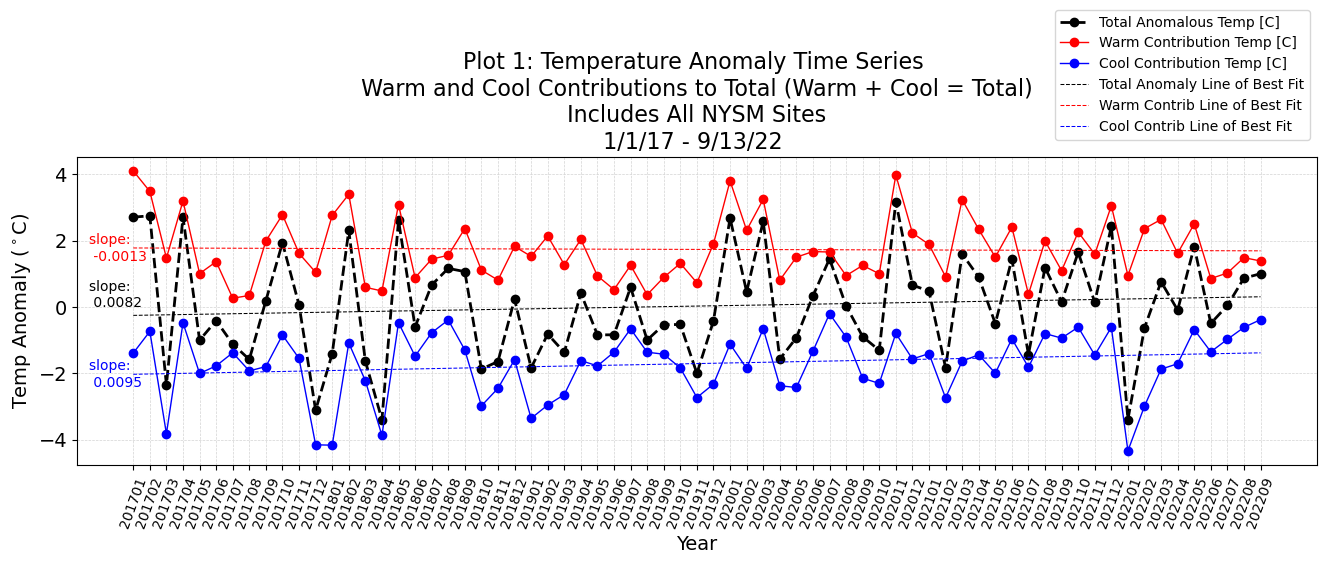

In [38]:
plot_contribs_timeseries(df_plot['yearmo'],df_plot['temp_2m[C]_anomaly'], df_plot['warm_contrib'], df_plot['cool_contrib'],trend_t_time, trend_warmcontrib_time, trend_coolcontrib_time, 'Plot 1: Temperature Anomaly Time Series \n Warm and Cool Contributions to Total (Warm + Cool = Total)')

#### Plot 2 - Temperature Anomaly Magnitude

In [39]:
def plot_tmag_timeseries(xplot,yavg, yhot,  ycold, trend1, trend2, trend3, title1): 

    ## Create figure of a particular size
    fig = plt.figure(figsize=(18, 6))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(xplot, yavg, label='Avg Magnitude Anom Temp [C]', color='black',linewidth=2, markersize = 6, marker='o', linestyle = '--') #, marker='o'
    ax1.plot(xplot, yhot, label='Warm Day Magnitude Anom Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    ax1.plot(xplot, ycold, label='Cool Day Magnitude Anom Temp  [C]', color='blue',linewidth=1, markersize = 6, marker='o') #, marker='o'

    # add lines of best fit
    x = np.array(range(0, len(xplot))) # time list format needed
    ax1.plot(x, trend1[0]*x + trend1[1], color = 'black', linewidth = 0.75, linestyle = '--', label='Avg Magnitude Anom Line of Best Fit')
    ax1.text(-3, 3.7, f"slope: \n {round(trend1[0],4)}", fontsize=10, color = 'black')
    # ax1.text(-2.9, 2.5, f"slope: \n {round(trend2[0],4)}", fontsize=10, color = 'red')
    # ax1.text(-2.9, 1.5, f"slope: \n {round(trend3[0],4)}", fontsize=10, color = 'blue')
    ax1.plot(x, trend2[0]*x + trend2[1], color = 'red', linewidth = 0.75, linestyle = '--', label='Avg Anomaly Line of Best Fit')
    ax1.plot(x, trend3[0]*x + trend3[1], color = 'blue', linewidth = 0.75, linestyle = '--', label='Avg Anomaly Line of Best Fit')

    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1.2)) 
    

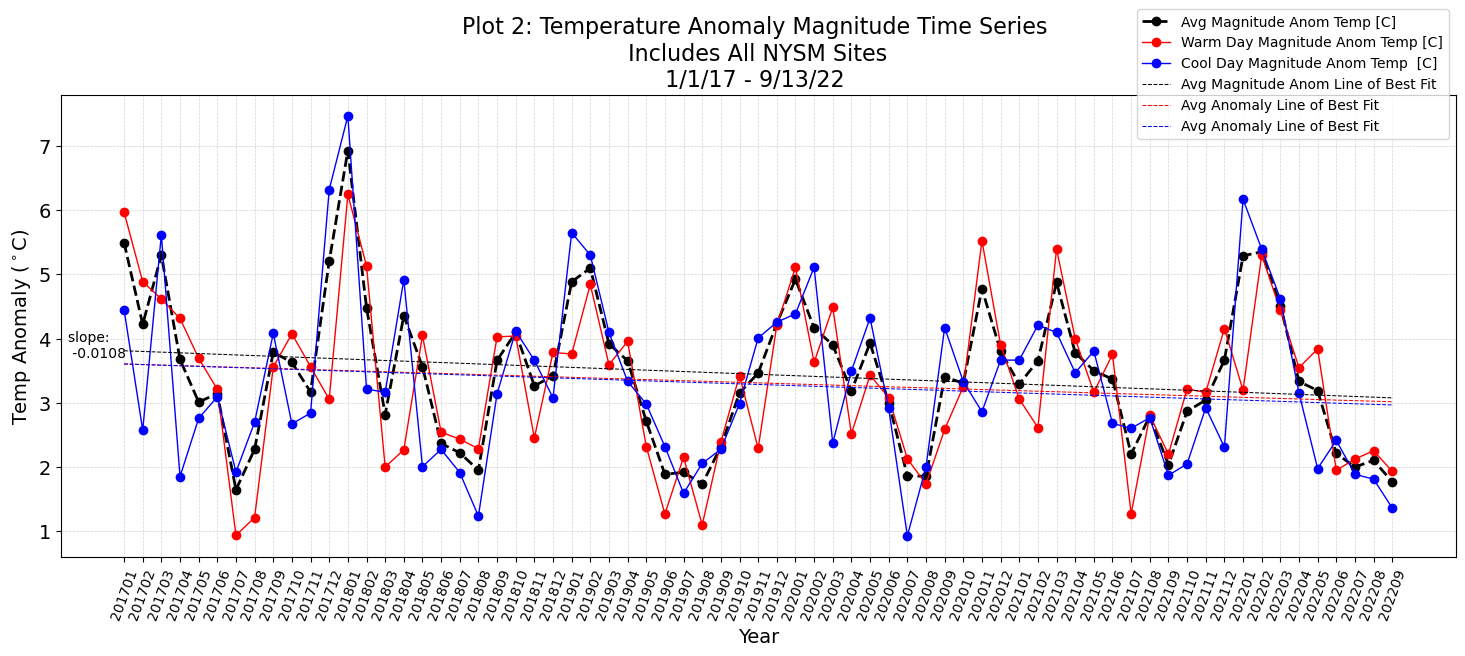

In [40]:
plot_tmag_timeseries(df_plot['yearmo'],df_plot['abs_anom'], df_plot['warm_anom'], df_plot['cool_anom'],trend_abst_time,  trend_warm_time,  trend_coolabs_time, 'Plot 2: Temperature Anomaly Magnitude Time Series')

#### Plot 3: Percentage of total days having warm anomaly

In [41]:
def plot_warmdayspercent_timeseries(xplot,yavg, trend1, title1): 

    ## Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(xplot, yavg, label='Avg Anomalous Temp [C]', color='black',linewidth=2, markersize = 6, marker='o', linestyle = '--') #, marker='o'
    # ax1.plot(xplot, yhot, label='Warm Anomalous Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    # ax1.plot(xplot, ycold, label='Cool Anomalous Temp [C]', color='blue',linewidth=1, markersize = 6, marker='o') #, marker='o'

    # add lines of best fit
    x = np.array(range(0, len(xplot))) # time list format needed
    ax1.plot(x, trend1[0]*x + trend1[1], color = 'black', linewidth = 0.75, linestyle = '--', label='Avg Anomaly Line of Best Fit')
    
    
    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('% of Days having Warm Anomaly', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right')  

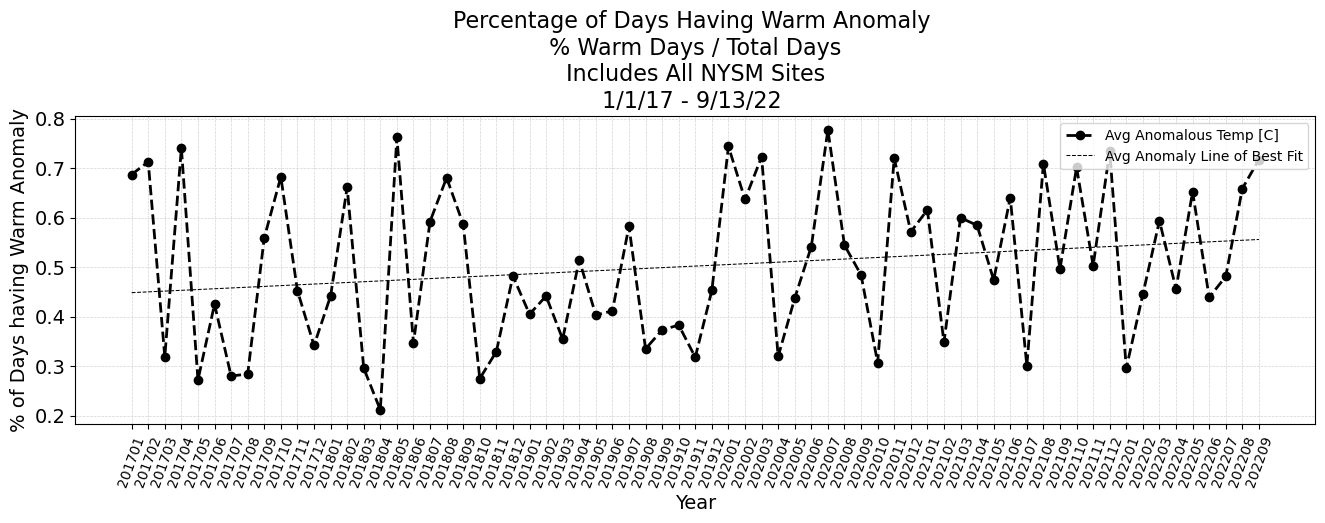

In [42]:
plot_warmdayspercent_timeseries(df_plot['yearmo'], df_plot['warm_anom_percent_days'], trend_warmdays_time, "Percentage of Days Having Warm Anomaly \n % Warm Days / Total Days")

#### Insights from time series plots:
<div class="alert alert-block alert-success">
<ol>

In Plot 1, we see a slight increase in overall temp anomaly being driven by a change in cold anomalies. We can conclude this because the trend lines indicate that the warm contribution is decreasing (slope -0.0013), implying a cooling over time. The cool contribution (anomalies less than 0) is increasing with slope of 0.0095, implying a warming over time. But the cool contribution "warming" is faster than the warm contribution "cooling", thus leading to a small overall anomolous temperature increase. 

Two factors play into the warm or cool contribution to total temp anomly in a given month: 1) the number of warm or cool days and 2) the extremeness of the warm or cool temps, i.e. the magnitudes. Plots 2 and 3 inspect these two factors. From plot 3, we can see that the percentage of warm days (rather than cool days) is trending up with time, and from plot 2, we can see that the magnitudes of both warm and cool anomalies are decreasing. These two plots help provide views in each warm and cool contribution, for example, 202107 total temperature anomaly was close to -2 degrees [C] (Plot 1) driven by a large number of cool days, nearly 70% (Plot 3). Both the warm and cool anomaly magnitudes were below average. As another example, the 202009 total temperature anomaly was close to -1 degree [C] but the days were split nearly 50/50 between warm and cool days, so the overall temp anomaly was driven by the magnitude of the cool anomalies which were on average about 1.5 degrees larger than the warm anomaly magnitudes.
   
    
Also note that the correlation between magnitude of anomalies in warm and cold days is similar, i.e. in months where the avg magnitude of warm days is large, the avg magnitude of the cold days is also large. 

Time series and resulting trends here are just with the 6 years of available NYSM data and  analyses should be redone in the future as more data becomes available. It is important to note that there is large variability with only a linear correlation of 0.10, indicating a weak linear relationship in the change of temp anomaly over time. 

    
</ol>
</div>

#### Site specific statistics
Gather bulk statistics by site for 1) trends over time for temp anomalies and 2) correlation of warm and cool anomalies

In [43]:
def site_bulk_stats():
    # list stats by site, appended to this list from loop
    site_stats = []

    sites = df_final['station'].unique()
    for site in sites:
        df_site = df_final[(df_final['station'] == site)]
        # df_site = df_site.dropna()
        df_out = df_to_plot(df_site)
        corr_warm_cool, corr_t_time, trend_t_time, trend_abst_time, trend_warm_time, trend_coolabs_time,  trend_coolval_time, trend_warmdays_time, trend_cooldays_time, trend_warmcontrib_time, trend_coolcontrib_time  = linear_stats(df_out)
        site_stats.append((site, corr_warm_cool, corr_t_time[0][1], trend_t_time[0], trend_abst_time[0], trend_warm_time[0], trend_coolabs_time[0],  trend_coolval_time[0], trend_warmdays_time[0], trend_cooldays_time[0], trend_warmcontrib_time[0], trend_coolcontrib_time[0]))


    df_site_trends = pd.DataFrame(site_stats, columns = ['site', 'correl_warm_cool', 'corr_t_time', 'trend_time_t_anom', 'trend_time_mag_anom', 'trend_time_warm_anom', 'trend_time_coolabs_anom', 'trend_time_coolval_anom','trend_warmdays_time', 'trend_cooldays_time', 'trend_warmcontrib_time', 'trend_coolcontrib_time'])

    df_site_trends = df_site_trends[['site', 'trend_time_t_anom', 'corr_t_time', 'trend_warmcontrib_time', 'trend_coolcontrib_time']].sort_values('trend_time_t_anom', ascending=[False])
    return df_site_trends

df_site_trends = site_bulk_stats()

# Inspect the resulting dataframe to find the sites with highest trends
df_site_trends 

,site,trend_time_t_anom,corr_t_time,trend_warmcontrib_time,trend_coolcontrib_time
124,WOLC,0.019688,0.242129,0.006825,0.012863
48,GFAL,0.018381,0.242014,0.005500,0.012880
62,LAUR,0.018324,0.226957,0.006513,0.011811
16,BUFF,0.017985,0.211436,0.004893,0.013093
102,STAT,0.016018,0.242727,0.003132,0.012886
...,...,...,...,...,...
77,OSWE,0.001619,0.019681,-0.005600,0.007219
98,SOME,0.001231,0.012935,-0.009611,0.155369
122,WGAT,0.001159,0.014375,-0.003514,0.004673
123,WHIT,0.000917,0.010284,-0.007883,0.008800


##### Plot a few of the highest temp trending sites

1. Plot WOLC (Wolcott)

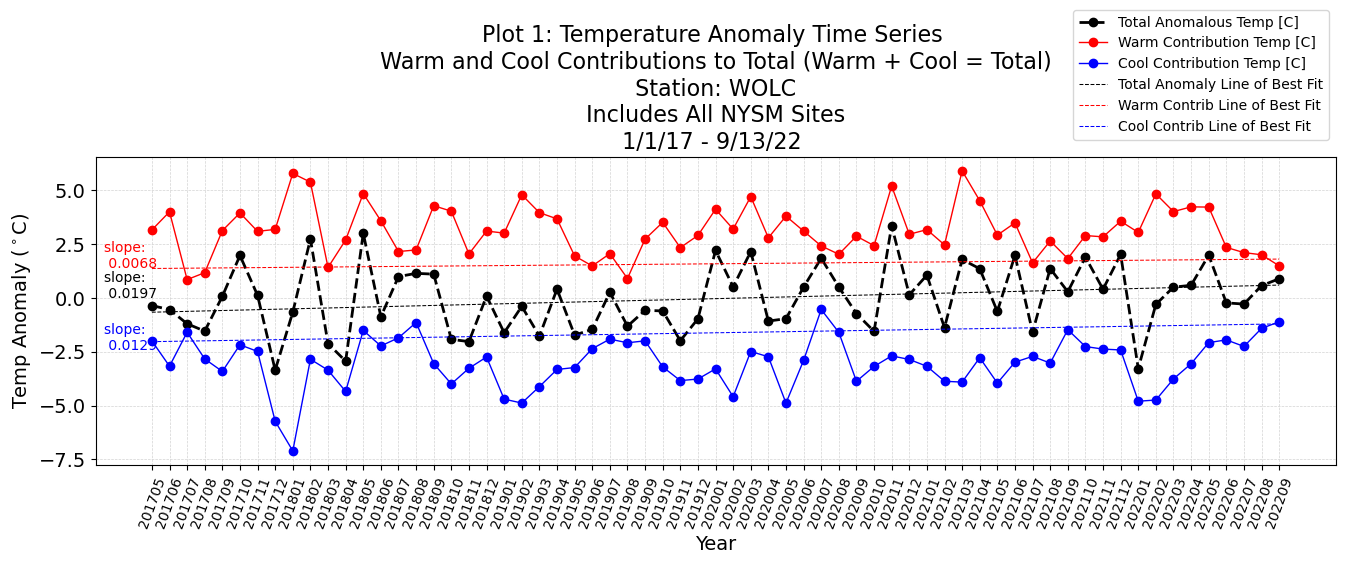

In [44]:
site = 'WOLC'
df_site = df_final[(df_final['station'] == site)]
# df_site = df_site.dropna()
df_out = df_to_plot(df_site)
corr_warm_cool, corr_t_time, trend_t_time, trend_abst_time, trend_warm_time, trend_coolabs_time,  trend_coolval_time, trend_warmdays_time, trend_cooldays_time, trend_warmcontrib_time, trend_coolcontrib_time  = linear_stats(df_out)
plot_contribs_timeseries(df_out['yearmo'],df_out['temp_2m[C]_anomaly'], df_out['warm_anom'], -df_out['cool_anom'],trend_t_time, trend_warmcontrib_time, trend_coolcontrib_time, f'Plot 1: Temperature Anomaly Time Series \n Warm and Cool Contributions to Total (Warm + Cool = Total) \n Station: {site}')

2. Plot STAT (Staten Island)

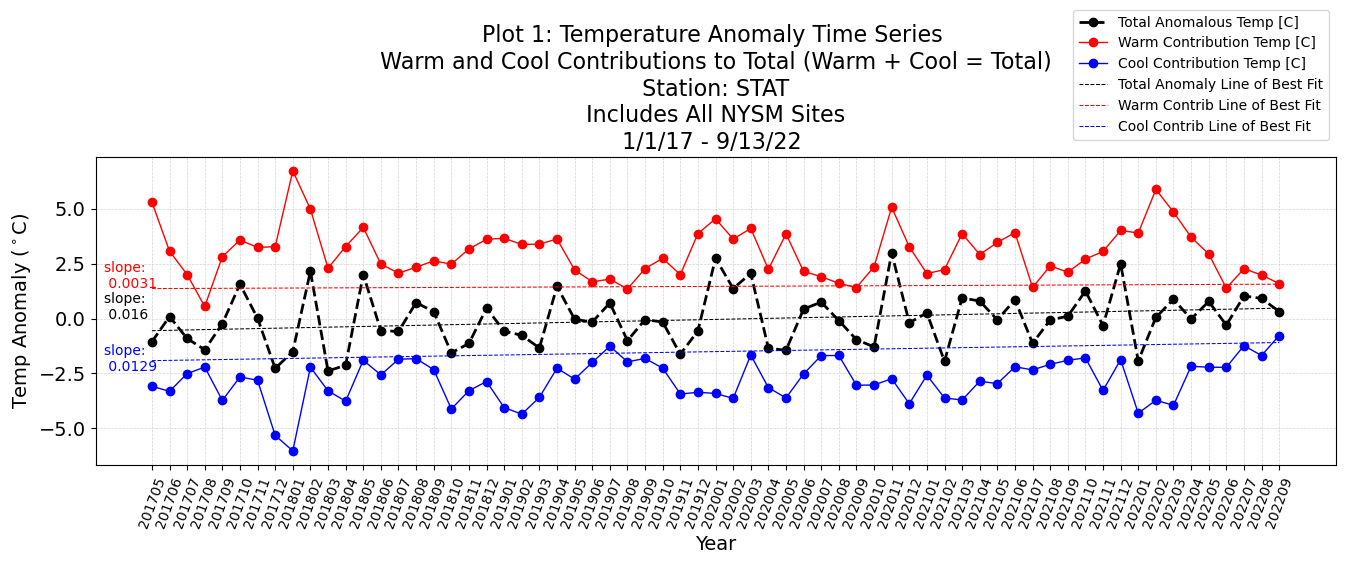

In [45]:
site = 'STAT'
df_site = df_final[(df_final['station'] == site)]
# df_site = df_site.dropna()
df_out = df_to_plot(df_site)
corr_warm_cool, corr_t_time, trend_t_time, trend_abst_time, trend_warm_time, trend_coolabs_time,  trend_coolval_time, trend_warmdays_time, trend_cooldays_time, trend_warmcontrib_time, trend_coolcontrib_time  = linear_stats(df_out)
plot_contribs_timeseries(df_out['yearmo'],df_out['temp_2m[C]_anomaly'], df_out['warm_anom'], -df_out['cool_anom'],trend_t_time, trend_warmcontrib_time, trend_coolcontrib_time, f'Plot 1: Temperature Anomaly Time Series \n Warm and Cool Contributions to Total (Warm + Cool = Total) \n Station: {site}')

3. Plot GFAL (Glens Falls)

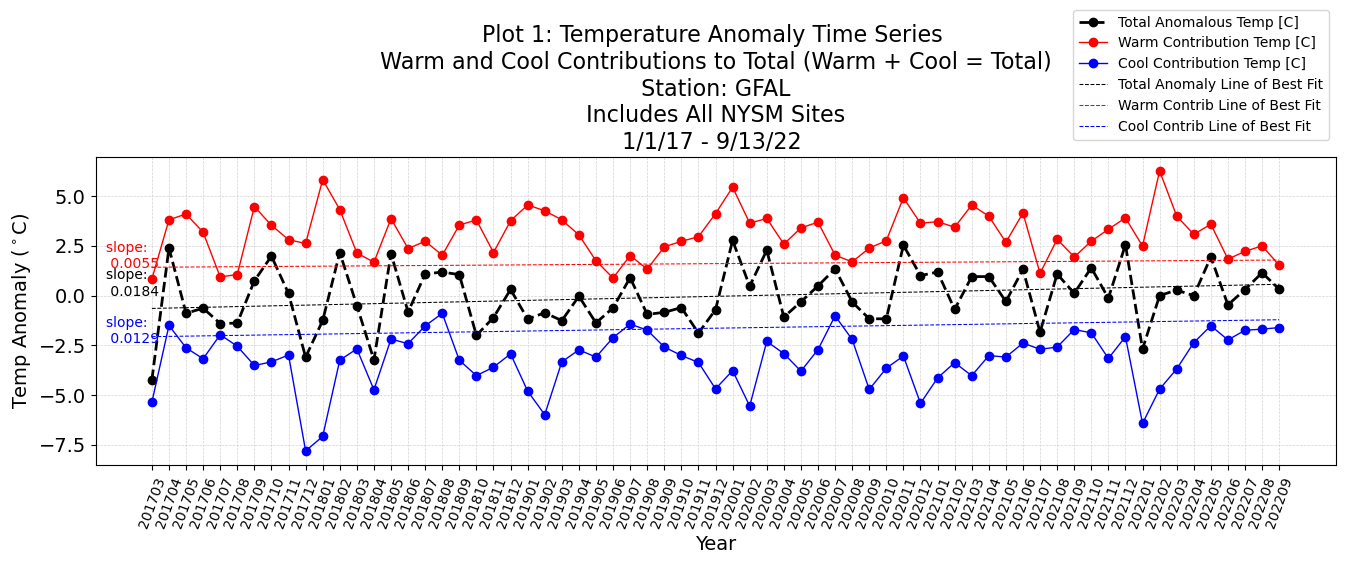

In [46]:
site = 'GFAL'
df_site = df_final[(df_final['station'] == site)]
# df_site = df_site.dropna()
df_out = df_to_plot(df_site)
corr_warm_cool, corr_t_time, trend_t_time, trend_abst_time, trend_warm_time, trend_coolabs_time,  trend_coolval_time, trend_warmdays_time, trend_cooldays_time, trend_warmcontrib_time, trend_coolcontrib_time  = linear_stats(df_out)
plot_contribs_timeseries(df_out['yearmo'],df_out['temp_2m[C]_anomaly'], df_out['warm_anom'], -df_out['cool_anom'],trend_t_time, trend_warmcontrib_time, trend_coolcontrib_time, f'Plot 1: Temperature Anomaly Time Series \n Warm and Cool Contributions to Total (Warm + Cool = Total) \n Station: {site}')

### 3F: Count of Anomalous Days - Bar Plot
- Sources referenced: 
    - https://stackoverflow.com/questions/48238305/bar-plot-with-groupby
    - https://stackoverflow.com/questions/56787466/how-to-create-a-stacked-percentage-bar-graph-from-a-dataframe-with-percentage-va

In [47]:
def anom_ct(seas):
    """ 
    Plotting function takes in season or the string "Annually" and plots the bar chart counting the anomalous days
    """
    if seas == 'Annually':  
        std1 = df_final[['year', 'std_bins']].groupby('std_bins').year.value_counts().unstack(0).reset_index()
    else: 
        std1 = df_final[['year', 'season', 'std_bins']][df_final['season'] == seas].groupby('std_bins').year.value_counts().unstack(0).reset_index()
    
    std1 = std1.rename_axis(None, axis=1)
    std1['Total'] = std1[1.0] + std1[2.0] + std1[3.0]

    std1['Non_anomalous_days'] = (std1[1.0]/std1['Total'])*100
    std1['Anomalous_days_within_2_standard_deviations'] = (std1[2.0]/std1['Total'])*100
    std1['Anomalous_days_3_or_more_standard_deviations'] = (std1[3.0]/std1['Total'])*100
    
    # reduce df before plotting to remove warning
    std2 = std1[['year', 'Non_anomalous_days', 'Anomalous_days_within_2_standard_deviations', 'Anomalous_days_3_or_more_standard_deviations']]

    plot = std2.plot(x='year', 
                     y = ['Non_anomalous_days', 'Anomalous_days_within_2_standard_deviations', 'Anomalous_days_3_or_more_standard_deviations'], 
                     kind='bar', 
                     ylabel = '% of total days',
                     stacked=True, 
                     title=f'Anomalous Days as % of Total Days \n {seas}')


    plot.legend(loc="lower right")

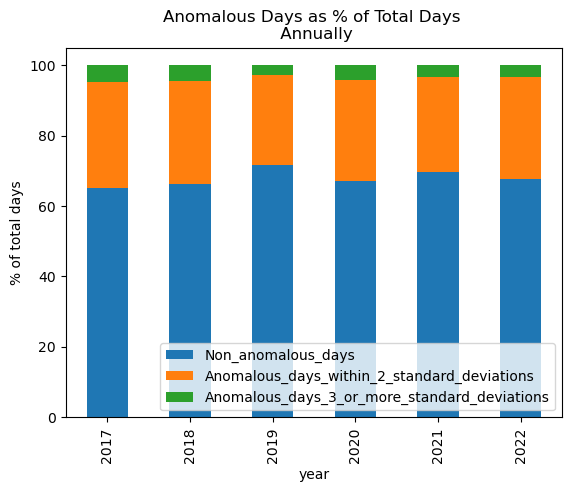

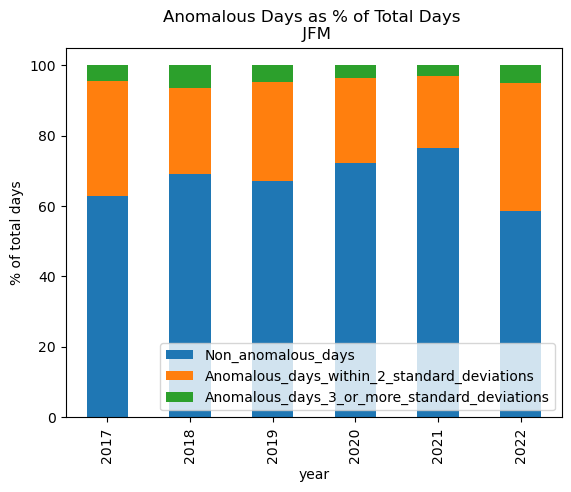

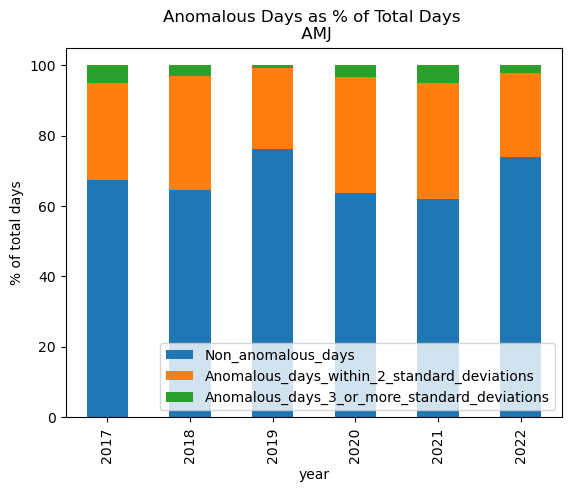

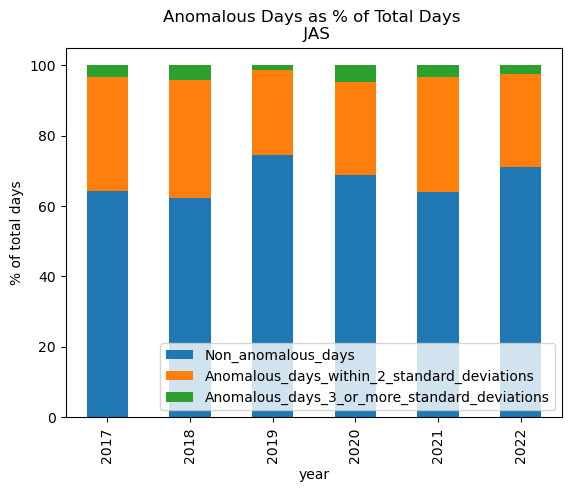

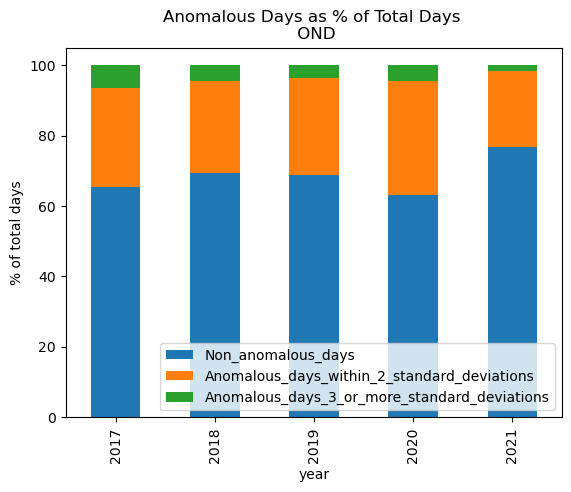

In [48]:
# Plot annual bar charts
anom_ct('Annually')

# Plot seasonal bar charts (loop through)
seasons = ['JFM', 'AMJ', 'JAS', 'OND']
for season in seasons:
    anom_ct(season)


#### Insights from counting anomalous events:
<div class="alert alert-block alert-success">
<ol>
There is no clear evidence of an increase in the count of anomalous days with time, annually nor by season
    
</ol>
</div>

### 3G: Count ***prolonged*** anomalous events which we'll define as 4 days that were more than a standard deviation away

#### Calculate the number of days belonging to prolonged anomalous events

In [49]:
def prolong_event_ls():
    """
    Loop through each station and season and count the number of days belonging to a "prolonged anomolous event" within that season time period. 
    Must do by site before combining. 
    Loop takes a couple of minutes to run
    """
    
    # for stations and years
    stations = df_final['station'].unique().tolist()
    years = df_final['year'].unique().tolist()

    # for counting sequence of days to count it as "prolonged"
    threshold = 4 # this is min length of sequence to count
    var_to_count = 'Y'

    site_year_entry = []

    for site in stations:
        for yr in years:
            for season in seasons:
                #append site and year for tracking 
                # subset df and make sure it's ordered by date so that cumulative sum works
                df_site_yr = df_final[(df_final['year']==yr)& ~(df_final['stds_away'].isna()) & (df_final['season']==season) & (df_final['station']==site)]
                df_site_yr = df_site_yr.sort_values(by=['date'])
                df_site_yr = df_site_yr.sort_values(by=['station'])
                df_site_yr = df_site_yr.reset_index()
                total_site_yr = (len(df_site_yr) if len(df_site_yr)>0 else 1) # used for looping and for appending for normalization
                my_out = [0 for i in range(0, total_site_yr)]
                # count number of consecutive days
                counter = 0 # number of times var_to_count shows up
                my_data = df_site_yr['std_consec'].to_list()
                my_out = [0 for i in range(0, len(my_data))] # this is the output list... 1 means count, 0 means don't count; initially all is 0.
                counter = 0 # number of times var_to_count shows up
                for i in range(0, len(my_data)):
                    if my_data[i] == var_to_count:
                        counter += 1
                        if counter == threshold: # if it's exactly the threshold, go back and fill in yesses.
                            for j in range(0, counter):
                                my_out[i - j] = 1 # since we're at the threshold, set the previous values to 1 now
                        if counter > threshold: # now we just keep adding 1s
                            my_out[i] = 1
                    else: # if the variable doesn't show up
                        counter = 0
                amt = sum(my_out)
                relative_consec_4d_2std = (amt/total_site_yr)*100
                site_year_entry.append((yr, site, season,total_site_yr, amt, relative_consec_4d_2std))
    return site_year_entry


site_year_entry = prolong_event_ls()


#### Turn data of prolonged events into dataframe and then aggregate by year and season

In [50]:
def create_df_aa_nysm():
    df_consec_cts_season_year = pd.DataFrame(site_year_entry , columns = ['Year', 'Station', 'Season', 'Days', 'Count_Days_2std_4dconsec', 'percent_days_belong_consec'])
    df_consec_cts_season = df_consec_cts_season_year[['Year', 'Season', 'Days', 'Count_Days_2std_4dconsec']].groupby(['Year', 'Season']).sum()
    df_consec_cts_season.reset_index(inplace=True)
    df_consec_cts_season['Percent_Days_2std_4dconsec'] = round((df_consec_cts_season['Count_Days_2std_4dconsec'] / df_consec_cts_season['Days'])*100,2)
    df_consec_cts_season.loc[df_consec_cts_season['Season'] == 'JFM', 'Season_Order'] = 'Season1'
    df_consec_cts_season.loc[df_consec_cts_season['Season'] == 'AMJ', 'Season_Order'] = 'Season2'
    df_consec_cts_season.loc[df_consec_cts_season['Season'] == 'JAS', 'Season_Order'] = 'Season3'
    df_consec_cts_season.loc[df_consec_cts_season['Season'] == 'OND', 'Season_Order'] = 'Season4'
    df_consec_cts_season['YearSeasonOrder'] = df_consec_cts_season['Year'] +"_"+ df_consec_cts_season['Season_Order']
    df_consec_cts_season['YearSeason'] = df_consec_cts_season['Year'] +"_"+ df_consec_cts_season['Season']
    # order by year_season
    df_consec_cts_season = df_consec_cts_season.sort_values('YearSeasonOrder')
    return df_consec_cts_season

df_consec_cts_season = create_df_aa_nysm()
df_consec_cts_season

,Year,Season,Days,Count_Days_2std_4dconsec,Percent_Days_2std_4dconsec,Season_Order,YearSeasonOrder,YearSeason
2,2017,JFM,9615,934,9.71,Season1,2017_Season1,2017_JFM
0,2017,AMJ,10718,778,7.26,Season2,2017_Season2,2017_AMJ
1,2017,JAS,11383,1708,15.00,Season3,2017_Season3,2017_JAS
3,2017,OND,11418,834,7.30,Season4,2017_Season4,2017_OND
6,2018,JFM,11236,632,5.62,Season1,2018_Season1,2018_JFM
4,2018,AMJ,11466,1873,16.34,Season2,2018_Season2,2018_AMJ
5,2018,JAS,11592,1683,14.52,Season3,2018_Season3,2018_JAS
7,2018,OND,11550,361,3.13,Season4,2018_Season4,2018_OND
10,2019,JFM,11329,1266,11.17,Season1,2019_Season1,2019_JFM
8,2019,AMJ,11458,122,1.06,Season2,2019_Season2,2019_AMJ


#### Plot time series of the prolonged anamolous events over time

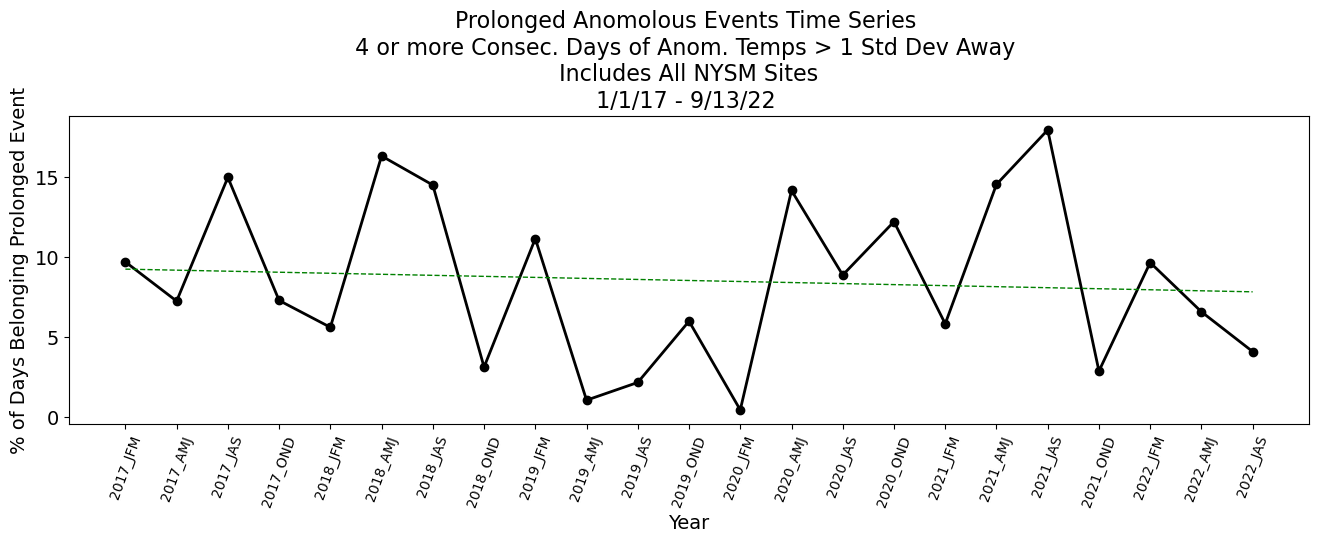

In [51]:
def plot_tanom_timeseries(xplot, yavg, title1):

    # Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(xplot, yavg, label = 'Day Counts Normalized to Total # of Days', color='black',linewidth=2, markersize = 6, marker='o') #, marker='o'
    
    # add line of best fit
    x = np.array(range(0, len(xplot)))
    y = np.array(yavg)
    m, b = np.polyfit(x, y, 1) 
    ax1.plot(x, m*x + b, color = 'green', linewidth = 1, linestyle = '--', label='Line of Best Fit')

    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('% of Days Belonging Prolonged Event', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)

    
# Create Plot (remove 2022 OND)
time_plot = df_consec_cts_season['YearSeason'][0:23] 
anom_plot = df_consec_cts_season['Percent_Days_2std_4dconsec'][0:23]

plot_tanom_timeseries(time_plot, anom_plot,'Prolonged Anomolous Events Time Series \n 4 or more Consec. Days of Anom. Temps > 1 Std Dev Away ') 


#### Insights from prolonged anomolous events time series:
<div class="alert alert-block alert-success">
<ol>
There is no clear evidence of the amount of prolonged anomalous days increasing or decreasing over the past 6 years
    
</ol>
</div>

## Section 4: Connecting AA and NYSM Trends

### Create dataframe of AA and NYSM Data by season from 2017 through 2021

In [52]:
def create_df_aa_nysm():
    nysm_df_compare_aa = df_final[['date', 'year', 'month', 'season', 'temp_2m[C]_anomaly']]
    nysm_df_compare_aa['YearSeason'] = nysm_df_compare_aa['year']+"_"+nysm_df_compare_aa['season']
    nysm_df_compare_aa['Anom_Mag'] = abs(nysm_df_compare_aa['temp_2m[C]_anomaly'])
    nysm_df_season_anom = nysm_df_compare_aa[['temp_2m[C]_anomaly','YearSeason', 'Anom_Mag']].groupby('YearSeason').mean()
    nysm_df_season_anom.reset_index(inplace=True)

    cfsr_aa_compare = cfsr_2017_2021_df.merge(nysm_df_season_anom, how = 'inner', left_on = ['YearSeason'], right_on = ['YearSeason'])
    cfsr_aa_compare['AA'] = pd.to_numeric(cfsr_aa_compare['AA'])
    return cfsr_aa_compare

cfsr_aa_compare = create_df_aa_nysm()

cfsr_aa_compare

/tmp/ipykernel_2224940/438401949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nysm_df_compare_aa['YearSeason'] = nysm_df_compare_aa['year']+"_"+nysm_df_compare_aa['season']
/tmp/ipykernel_2224940/438401949.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nysm_df_compare_aa['Anom_Mag'] = abs(nysm_df_compare_aa['temp_2m[C]_anomaly'])


,YearSeason,YearSeasonOrder,AA,temp_2m[C]_anomaly,Anom_Mag
0,2017_JFM,2017_Season1,2.21,0.942415,5.031751
1,2017_AMJ,2017_Season2,0.03,0.376313,3.266758
2,2017_JAS,2017_Season3,0.26,-0.846396,2.560772
3,2017_OND,2017_Season4,2.76,-0.372417,4.006571
4,2018_JFM,2018_Season1,2.45,-0.332534,4.738474
5,2018_AMJ,2018_Season2,0.37,-0.429772,3.431138
6,2018_JAS,2018_Season3,0.31,0.960998,2.599327
7,2018_OND,2018_Season4,2.07,-1.093407,3.596367
8,2019_JFM,2019_Season1,0.96,-1.361199,4.618198
9,2019_AMJ,2019_Season2,1.36,-0.428930,2.750421


#### Plot time series of AA and NYSM Anomalies by season from 2017-2021

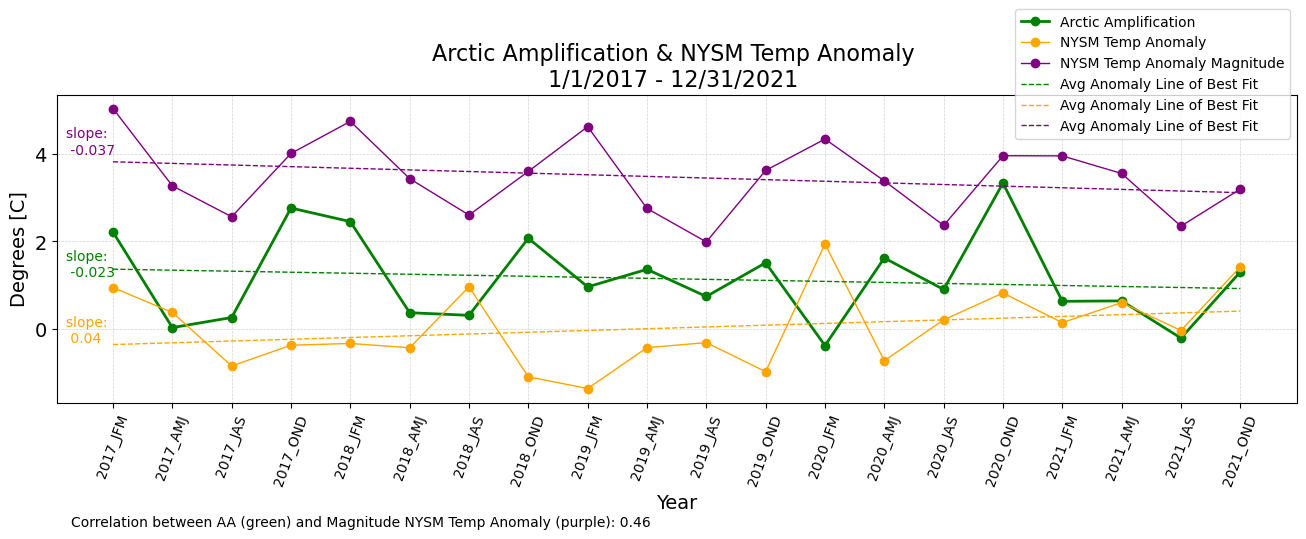

In [53]:
def plot_tanom_timeseries(xplot,y1, y2, y3, title1):

    ## Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)
    # ax2 = ax1.twinx()

    ax1.plot(xplot, y1, label='Arctic Amplification', color='green',linewidth=2, markersize = 6, marker='o') #, marker='o'
    ax1.plot(xplot, y2, label='NYSM Temp Anomaly', color='orange',linewidth=1, markersize = 6, marker='o') #, marker='o'
    ax1.plot(xplot, y3, label='NYSM Temp Anomaly Magnitude', color='purple',linewidth=1, markersize = 6, marker='o') #, marker='o'

    # ax1.plot(xplot, yhot, label='Warm Anomalous Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    
    # add line of best fit
    x = np.array(range(0, len(xplot)))
    y1_ar = np.array(y1)
    m1, b1 = np.polyfit(x, y1_ar, 1) 
    ax1.plot(x, m1*x + b1, color = 'green', linewidth = 1, linestyle = '--', label='Avg Anomaly Line of Best Fit')
    y2_ar = np.array(y2)
    m2, b2 = np.polyfit(x, y2_ar, 1) 
    ax1.plot(x, m2*x + b2, color = 'orange', linewidth = 1, linestyle = '--', label='Avg Anomaly Line of Best Fit')
    corr = np.corrcoef(y1_ar, y2_ar)
    y3_ar = np.array(y3)
    m3, b3 = np.polyfit(x, y3_ar, 1) 
    ax1.plot(x, m3*x + b3, color = 'purple', linewidth = 1, linestyle = '--', label='Avg Anomaly Line of Best Fit')
    corr_anom = np.corrcoef(y1_ar, y2_ar)
    corr_anom_mag = np.corrcoef(y1_ar, y3_ar)

    ax1.text(-.8, 1.2, f"slope: \n {round(m1,3)}", fontsize=10, color = 'green')
    ax1.text(-.8, -.3, f"slope: \n {round(m2,3)}", fontsize=10, color = 'orange')
    ax1.text(-.8, 4, f"slope: \n {round(m3,3)}", fontsize=10, color = 'purple')
    ax1.text(-.7, -4.5, f"Correlation between AA (green) and Magnitude NYSM Temp Anomaly (purple): {round(corr_anom_mag[0][1],2)}", fontsize=10, color = 'black')

    
    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n 1/1/2017 - 12/31/2021  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('Degrees [C]', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1.3)) 
    
plot_tanom_timeseries(cfsr_aa_compare['YearSeason'],cfsr_aa_compare['AA'], cfsr_aa_compare['temp_2m[C]_anomaly'], cfsr_aa_compare['Anom_Mag'], 'Arctic Amplification & NYSM Temp Anomaly')

#### Insights from prolonged anomolous events time series:
<div class="alert alert-block alert-success">
<ol>
By looking at the AA values for years when we have NYSM data, we can compare trends and relationships between the two. There is a correlation of 0.46 between AA and the NYSM average temp anomaly magnitudes. Seasons with higher temperature anomaly magnitudes have anomalous temperatures with larger deviations from expected. 
</ol>
</div>

___

## Summary

We have used CFSR data from 1979-2021 to show that Arctic Amplification is occuring. The effect of AA on mid-latitude weather is debated, with atmospheric models suggesting that there are multiple ways that AA could affect weather, both for <b> more extreme </b> weather conditions in the mid-latitudes or <b>less extreme </b>conditions in mid-latitudes (see papers below). 

We explored trends in anomalous temperatures in NY State using NYSM data from 2017-2022 (through Sep). We found that the overall temperature anomalies are slightly increasing with time (driven by changes in cold anomalies), but the magnitude of temperature anomalies has a slight decrease. As shown in the last plot (Section 4), the magnitude of anomalies has a correlation with AA of 0.46. However, it is crucial to emphasize that correlation does not mean causation, so we cannot conclude from this student that AA is causing more extreme temperature anomalies in NYS. As discussed in Barnes & Screen (2015), observation-only studies linking AA to weather events is not enough;  there are multiple pathways to how AA may affect mid-latitude weather and climate models and dynamics must be considered.

Papers here: 
 - Jennifer A Francis and Stephen J Vavrus 2015 Environ. Res. Lett. 10 014005, https://iopscience.iop.org/article/10.1088/1748-9326/10/1/014005#erl507077bib8
- Elizabeth A Barnes and James A Screen 2015, https://wires.onlinelibrary.wiley.com/doi/10.1002/wcc.337

